Solving the Burgers equation using FVM to get a mass conserving solution

In [1]:
using Plots, JLD2

In [2]:
# setting up the problem

# parameters
nx=100     # number of spatial points
L=10.0     # length of the domain
Δx=L/nx    # spatial step
ν=0.1    # viscosity
k=2*pi/L   # wave number for initial condition
u_mean=1 # mean velocity
u_amplitude=0.5 # amplitude of the initial condition

x = range(Δx/2, L - Δx/2, length=nx) # cell-centered grid

# initial condition
u0(x) = u_mean .+ u_amplitude.*cos.(k*x)

# added noise strength for stabilizied learning
noise_strength=0

# time
cfl = 0.8
dt_out_target = cfl*Δx/u_mean
nt = 10000
t_end=15
Δt = t_end/nt
println("Using Δt = $Δt, nt = $nt")

Using Δt = 0.0015, nt = 10000


In [3]:
function convective_flux(u)
    n = length(u)
    flux = zeros(n)

    u_prev = circshift(u, 1)
    u_next = circshift(u, -1)

    for i in 1:n
        uL = u[i]
        uR = u_next[i]

        alpha = max(abs(uL), abs(uR))
        flux_LR = 0.25*(uL^2 + uR^2) - 0.5*alpha*(uR-uL)

        uL_prev = u_prev[i]
        uR_prev = u[i]

        alpha_prev = max(abs(uL_prev), abs(uR_prev))
        flux_prev = 0.25*(uL_prev^2 + uR_prev^2) - 0.5*alpha_prev*(uR_prev - uL_prev)
        
        flux[i] = (-1/Δx) * (flux_LR - flux_prev)
    end

    return flux
end

function diffusive_flux(u)
    n = length(u)
    flux = zeros(n)

    u_prev = circshift(u, 1)
    u_next = circshift(u, -1)

    for i in 1:n
        flux[i] = (ν/Δx^2) * (u_prev[i] - 2u[i] + u_next[i])
    end

    return flux
end

R(u) = convective_flux(u) .+ diffusive_flux(u)

function rk3_step(u, Δt)
    k1 = R(u)
    u1 = u .+ Δt .* k1

    k2 = R(u1)
    u2 = 0.75*u .+ 0.25*(u1 .+ Δt .* k2)

    k3 = R(u2)
    u_next = (1/3)*u .+ (2/3)*(u2 .+ Δt .* k3)

    return u_next
end;

In [4]:
sol = [u0(x)]
current_u = u0(x)

for n in 1:nt
    current_u = rk3_step(current_u, Δt)
    noised = ((rand(nx).-0.5)*2*noise_strength) .+ copy(current_u)
    push!(sol, noised)
end;

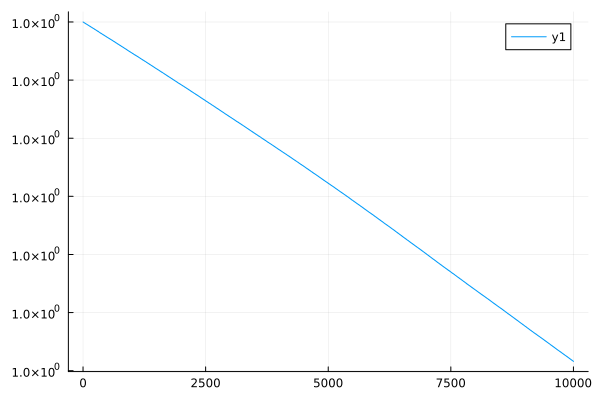

GKS: Possible loss of precision in routine SET_WINDOW


In [5]:
masses = []
for i in 1:length(sol)
    push!(masses, sum(sol[i])/length(sol[i]))
end
plot(masses)

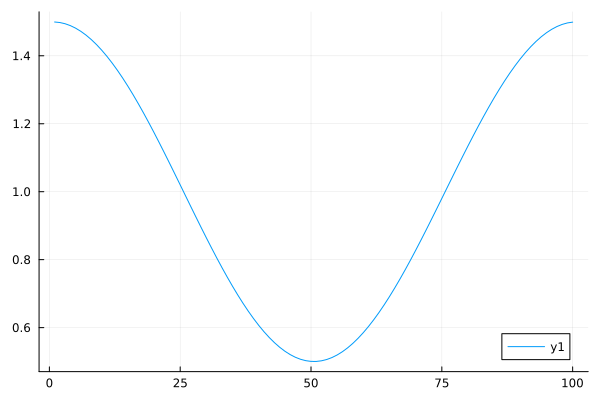

In [6]:
plot(sol[10])

In [7]:
cfl = 0.8
dt_out_target = cfl*Δx/u_mean
t_step = Int(floor(dt_out_target / Δt))
dt_out = t_step*Δt
times=collect(0.0:dt_out:t_end)

solution = []
for t_idx in 1:t_step:length(sol)
    push!(solution, sol[t_idx])
end

# save the solution to a JLD2 file
save("data/burgers1d_periodicTEMP.jld2", 
    "solution", solution,
    "times", times,
    "params", (ν=ν, Δx=Δx, u_mean=u_mean, u_amplitude=u_amplitude, k=k),
    "grid", x,
    "cfl_out", cfl,
    "dt_out", dt_out,
    "description", "Solution of the 1D Burgers equation with periodic boundary conditions, using a cosine as initial condition.")